<a href="https://colab.research.google.com/github/Wambui-123/TicTacToe-Game/blob/main/Game_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# --- Step 1: Environment Setup ---
def check_winner(board):
    win_states = [
        (0,1,2), (3,4,5), (6,7,8),  # rows
        (0,3,6), (1,4,7), (2,5,8),  # columns
        (0,4,8), (2,4,6)            # diagonals
    ]
    for (i, j, k) in win_states:
        if board[i] == board[j] == board[k] != 0:
            return board[i]
    if 0 not in board:
        return 0.5  # draw
    return None  # game ongoing

def available_actions(board):
    return [i for i in range(9) if board[i] == 0]

def make_move(board, action, player):
    if board[action] == 0:
        board[action] = player
        return True
    return False

def reset_board():
    return [0] * 9

In [3]:
# --- Step 2: State Representation ---
def get_state(board):
    return tuple(board)  # Use tuple as hashable state

In [4]:
# --- Step 3: Q-Learning Setup ---
Q = defaultdict(lambda: np.zeros(9))  # Q[state][action] = value

alpha = 0.1      # Learning rate
gamma = 0.9      # Discount factor
epsilon = 0.1    # Exploration rate

In [5]:
# --- Step 4  : ε-greedy Action Selection ---
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        return random.choice(available_actions(list(state)))
    else:
        q_vals = Q[state]
        valid_actions = available_actions(list(state))
        max_q = -float('inf')
        best_action = None
        for a in valid_actions:
            if q_vals[a] > max_q:
                max_q = q_vals[a]
                best_action = a
        return best_action

In [6]:
# --- Step 5: Training Loop ---
def train(episodes=10000):
    for episode in range(episodes):
        board = reset_board()
        state = get_state(board)
        done = False

        while not done:
            # Agent's move (Player 1)
            action = choose_action(state)
            if not make_move(board, action, 1):
                reward = -10  # Invalid move penalty
                Q[state][action] += alpha * (reward - Q[state][action])
                break

            next_state = get_state(board)
            result = check_winner(board)

            if result == 1:
                reward = 1  # Agent wins
                Q[state][action] += alpha * (reward - Q[state][action])
                break
            elif result == 0.5:
                reward = 0.5  # Draw
                Q[state][action] += alpha * (reward - Q[state][action])
                break
            else:
                reward = 0  # Neutral

            # Opponent (Random)
            opp_actions = available_actions(board)
            if not opp_actions:
                break
            opp_action = random.choice(opp_actions)
            make_move(board, opp_action, -1)
            result = check_winner(board)

            if result == -1:
                reward = -1  # Agent loses
                Q[state][action] += alpha * (reward - Q[state][action])
                break
            elif result == 0.5:
                reward = 0.5  # Draw
            else:
                reward = 0

            next_state = get_state(board)
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            state = next_state

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1} completed.")

# Train the agent
train(episodes=10000)

Episode 1000 completed.
Episode 2000 completed.
Episode 3000 completed.
Episode 4000 completed.
Episode 5000 completed.
Episode 6000 completed.
Episode 7000 completed.
Episode 8000 completed.
Episode 9000 completed.
Episode 10000 completed.


In [7]:
# --- Evaluation Function ---
def evaluate_agent(episodes=1000):
    wins, losses, draws = 0, 0, 0
    total_rewards = []

    for _ in range(episodes):
        board = reset_board()
        state = get_state(board)
        done = False
        total_reward = 0

        while not done:
            action = choose_action(state)
            if not make_move(board, action, 1):
                total_reward += -10
                break

            result = check_winner(board)
            if result == 1:
                wins += 1
                total_reward += 1
                break
            elif result == 0.5:
                draws += 1
                total_reward += 0.5
                break

            # Opponent (Random)
            opp_actions = available_actions(board)
            if not opp_actions:
                draws += 1
                total_reward += 0.5
                break
            opp_action = random.choice(opp_actions)
            make_move(board, opp_action, -1)

            result = check_winner(board)
            if result == -1:
                losses += 1
                total_reward += -1
                break
            elif result == 0.5:
                draws += 1
                total_reward += 0.5
                break

            state = get_state(board)

        total_rewards.append(total_reward)

    print("\nEvaluation over", episodes, "episodes")
    print(f"Wins: {wins} ({wins/episodes:.2%})")
    print(f"Losses: {losses} ({losses/episodes:.2%})")
    print(f"Draws: {draws} ({draws/episodes:.2%})")
    print(f"Average Reward: {np.mean(total_rewards):.3f}")

    return total_rewards, wins, losses, draws

In [8]:
# --- Training with Reward Tracking ---
def train_with_tracking(episodes=10000, eval_interval=1000):
    avg_rewards = []
    win_rates = []
    loss_rates = []
    draw_rates = []

    for ep in range(0, episodes, eval_interval):
        train(episodes=eval_interval)
        rewards, wins, losses, draws = evaluate_agent(episodes=500)

        avg_rewards.append(np.mean(rewards))
        win_rates.append(wins / 500)
        loss_rates.append(losses / 500)
        draw_rates.append(draws / 500)

    # Plotting
    x = list(range(eval_interval, episodes + 1, eval_interval))

    plt.figure(figsize=(12, 5))

    # Reward plot
    plt.subplot(1, 2, 1)
    plt.plot(x, avg_rewards, label='Average Reward', marker='o')
    plt.title('Average Reward Over Time')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.legend()

    # Win/Loss/Draw Rates
    plt.subplot(1, 2, 2)
    plt.plot(x, win_rates, label='Win Rate', marker='o')
    plt.plot(x, loss_rates, label='Loss Rate', marker='x')
    plt.plot(x, draw_rates, label='Draw Rate', marker='s')
    plt.title('Performance Metrics Over Time')
    plt.xlabel('Episodes')
    plt.ylabel('Rate')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


Episode 1000 completed.

Evaluation over 500 episodes
Wins: 424 (84.80%)
Losses: 27 (5.40%)
Draws: 49 (9.80%)
Average Reward: 0.843
Episode 1000 completed.

Evaluation over 500 episodes
Wins: 428 (85.60%)
Losses: 30 (6.00%)
Draws: 42 (8.40%)
Average Reward: 0.838
Episode 1000 completed.

Evaluation over 500 episodes
Wins: 437 (87.40%)
Losses: 19 (3.80%)
Draws: 44 (8.80%)
Average Reward: 0.880
Episode 1000 completed.

Evaluation over 500 episodes
Wins: 427 (85.40%)
Losses: 24 (4.80%)
Draws: 49 (9.80%)
Average Reward: 0.855
Episode 1000 completed.

Evaluation over 500 episodes
Wins: 434 (86.80%)
Losses: 29 (5.80%)
Draws: 37 (7.40%)
Average Reward: 0.847
Episode 1000 completed.

Evaluation over 500 episodes
Wins: 442 (88.40%)
Losses: 21 (4.20%)
Draws: 37 (7.40%)
Average Reward: 0.879
Episode 1000 completed.

Evaluation over 500 episodes
Wins: 433 (86.60%)
Losses: 24 (4.80%)
Draws: 43 (8.60%)
Average Reward: 0.861
Episode 1000 completed.

Evaluation over 500 episodes
Wins: 437 (87.40%)
Los

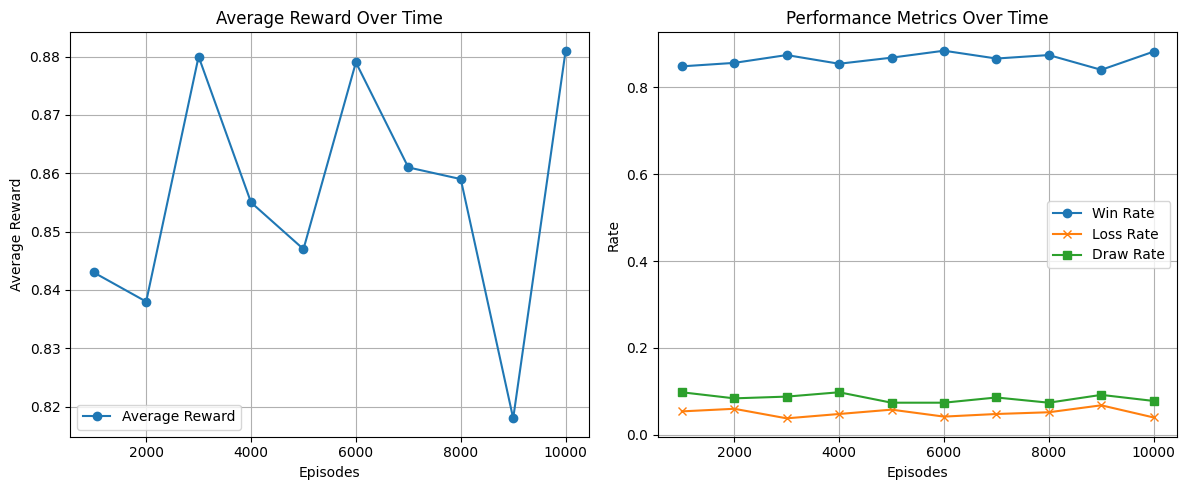

In [9]:
# --- Run Training + Evaluation + Visualization ---
train_with_tracking(episodes=10000, eval_interval=1000)

In [10]:
def print_board(board):
    symbols = {1: 'X', -1: 'O', 0: ' '}
    for i in range(3):
        row = [symbols[board[j]] for j in range(i * 3, (i + 1) * 3)]
        print(" | ".join(row))
        if i < 2:
            print("--+---+--")

In [11]:
def human_move(board):
    valid = available_actions(board)
    while True:
        try:
            move = int(input("Enter your move (0–8): "))
            if move in valid:
                return move
            else:
                print("Invalid move. Try again.")
        except ValueError:
            print("Enter a number from 0 to 8.")

In [12]:
def play_against_agent():
    print("\n--- Tic-Tac-Toe: Human (O) vs AI Agent (X) ---")
    board = reset_board()
    print_board(board)

    while True:
        # Agent (X) moves first
        state = get_state(board)
        action = choose_action(state)
        make_move(board, action, 1)
        print("\nAgent (X) moved:")
        print_board(board)

        result = check_winner(board)
        if result is not None:
            break

        # Human (O) move
        move = human_move(board)
        make_move(board, move, -1)
        print("\nYou (O) moved:")
        print_board(board)

        result = check_winner(board)
        if result is not None:
            break

    print("\n--- Game Over ---")
    if result == 1:
        print("Agent (X) wins!")
    elif result == -1:
        print("You (O) win!")
    elif result == 0.5:
        print("It's a draw!")


In [13]:
# --- Play the game ---
play_against_agent()


--- Tic-Tac-Toe: Human (O) vs AI Agent (X) ---
  |   |  
--+---+--
  |   |  
--+---+--
  |   |  

Agent (X) moved:
X |   |  
--+---+--
  |   |  
--+---+--
  |   |  
Enter your move (0–8): 5

You (O) moved:
X |   |  
--+---+--
  |   | O
--+---+--
  |   |  

Agent (X) moved:
X | X |  
--+---+--
  |   | O
--+---+--
  |   |  
Enter your move (0–8): 6

You (O) moved:
X | X |  
--+---+--
  |   | O
--+---+--
O |   |  

Agent (X) moved:
X | X |  
--+---+--
  |   | O
--+---+--
O |   | X
Enter your move (0–8): 5
Invalid move. Try again.
Enter your move (0–8): 8
Invalid move. Try again.
Enter your move (0–8): 7

You (O) moved:
X | X |  
--+---+--
  |   | O
--+---+--
O | O | X

Agent (X) moved:
X | X | X
--+---+--
  |   | O
--+---+--
O | O | X

--- Game Over ---
Agent (X) wins!


### Big Plus

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

##### Environment & Game Logic

In [15]:
def check_winner(board):
    win_states = [
        (0,1,2), (3,4,5), (6,7,8),
        (0,3,6), (1,4,7), (2,5,8),
        (0,4,8), (2,4,6)
    ]
    for i, j, k in win_states:
        if board[i] == board[j] == board[k] != 0:
            return board[i]
    if 0 not in board:
        return 0.5
    return None

def available_actions(board):
    return [i for i in range(9) if board[i] == 0]

def make_move(board, action, player):
    if board[action] == 0:
        board[action] = player
        return True
    return False

def reset_board():
    return [0] * 9

##### Deep Q-Network Model

In [16]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(9, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 9)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

##### DQN Training Loop

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
memory = deque(maxlen=10000)
batch_size = 64
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.05

def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.choice(available_actions(state))
    else:
        with torch.no_grad():
            q_values = policy_net(state).detach().numpy()
            available = available_actions(state)
            masked = [(i, q_values[i]) for i in available]
            best_action = max(masked, key=lambda x: x[1])[0]
            return best_action

def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*transitions)

    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1).to(device)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    expected_q_values = rewards + gamma * next_q_values * (~dones)

    loss = nn.MSELoss()(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


##### Train the DQN Agent

In [18]:
rewards_per_episode = []

for episode in range(10000):
    board = reset_board()
    state = np.array(board)
    done = False
    total_reward = 0

    while not done:
        action = select_action(state, epsilon)
        valid = make_move(board, action, 1)

        if not valid:
            reward = -10
            next_state = np.array(board)
            memory.append((state, action, reward, next_state, True))
            total_reward += reward
            break

        result = check_winner(board)
        if result == 1:
            reward = 1
            done = True
        elif result == 0.5:
            reward = 0.5
            done = True
        else:
            reward = 0
            # Opponent (random)
            opp_moves = available_actions(board)
            if opp_moves:
                opp_action = random.choice(opp_moves)
                make_move(board, opp_action, -1)
                result = check_winner(board)
                if result == -1:
                    reward = -1
                    done = True
                elif result == 0.5:
                    reward = 0.5
                    done = True

        next_state = np.array(board)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    optimize_model()

    if episode % 1000 == 0:
        target_net.load_state_dict(policy_net.state_dict())
        print(f"Episode {episode}, Total reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

Episode 0, Total reward: 1.00, Epsilon: 0.99


/tmp/ipython-input-16-3802402124.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Episode 1000, Total reward: 1.00, Epsilon: 0.05
Episode 2000, Total reward: 1.00, Epsilon: 0.05
Episode 3000, Total reward: 1.00, Epsilon: 0.05
Episode 4000, Total reward: 1.00, Epsilon: 0.05
Episode 5000, Total reward: 1.00, Epsilon: 0.05
Episode 6000, Total reward: 1.00, Epsilon: 0.05
Episode 7000, Total reward: 0.50, Epsilon: 0.05
Episode 8000, Total reward: 1.00, Epsilon: 0.05
Episode 9000, Total reward: 1.00, Epsilon: 0.05


In [19]:
import plotly.graph_objects as go
import numpy as np

# Smooth the reward curve (optional)
def moving_average(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Create Plotly Figure
def plot_rewards_plotly(rewards):
    smoothed_rewards = moving_average(rewards, window=100)

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=smoothed_rewards,
        mode='lines',
        name='Smoothed Reward (100-episode MA)',
        line=dict(color='royalblue')
    ))

    fig.update_layout(
        title='DQN Training Progress – Tic-Tac-Toe',
        xaxis_title='Episode',
        yaxis_title='Total Reward',
        template='plotly_white',
        showlegend=True,
        width=800,
        height=400
    )

    fig.show()


In [20]:
plot_rewards_plotly(rewards_per_episode)